### INTRO & GOALS

In this notebook, I will be generating some data to visualize where the GNN is at right now. I will be paying particular attention on how to generally run the GNN, but I will start looking at the X2 variable. We need to figure out the rollout loss function, but thats a later thing :) one step at a time, girl

goals: learn how to use this giant codebase PLEASEEE
        see what's goin on here, esp with X2 when compared to X1

### IMPORTS & SETUP

here, we'll import the necessary packages and  make sure auto reload is turned on

In [1]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2 

from utils.jraph_data import get_lorenz_graph_tuples, print_graph_fts
from utils.lorenz import load_lorenz96_2coupled

import numpy as np
import jax.numpy as jnp

### CONFIGS

In [2]:
import ml_collections

config = ml_collections.ConfigDict()

# Data params. 
config.n_samples=20
config.input_steps=3
config.output_delay=0
config.output_steps=2
config.timestep_duration=1
config.sample_buffer=1
config.time_resolution=100
config.init_buffer_samples=0
config.train_pct=0.7
config.val_pct=0.2
config.test_pct=0.1
config.K=36
config.F=8
config.c=10
config.b=10
config.h=1
config.seed=42
config.normalize=True
config.fully_connected_edges=True

# Optimizer.
config.optimizer = 'adam'
config.learning_rate = 1e-3

# Training hyperparameters.
# config.batch_size = 3
config.epochs = 2
config.log_every_epochs = 1
config.eval_every_epochs = 1
config.checkpoint_every_epochs = 1
config.max_checkpts_to_keep = None # None means keep all checkpoints

# GNN hyperparameters.
config.model = 'MLPGraphNetwork'
config.n_blocks = 1
config.activation = 'relu'
config.dropout_rate = 0.1
config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
config.layer_norm = False # TODO perhaps we want to turn on later
config.edge_features = (4, 8) # the last feature size will be the number of features that the graph predicts
config.node_features = (32, 2)
config.global_features = None
config.share_params = False

### LORENZ DATA

In [3]:
from utils.lorenz import run_download_lorenz96_2coupled, load_lorenz96_2coupled

Now, we'll run the model and save it to a .npz file, called sample

In [8]:
run_download_lorenz96_2coupled(
        fname="data/sample", 
        K=config.K,
        F=config.F,
        c=config.c,
        b=config.b,
        h=config.h,
        n_steps=100,
        resolution=config.time_resolution,
        seed=config.seed)

Let's load and visualize the data:

In [82]:
t, X = load_lorenz96_2coupled(fname="data/sample.npz")
print(X.shape)
X

(100, 72)


array([[ 8.        ,  8.        ,  8.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 7.9902934 ,  7.99291748,  7.990142  , ...,  0.9810261 ,
         0.98093732,  0.98058919],
       [ 7.98172884,  7.99153972,  7.98050267, ...,  0.9642227 ,
         0.96387367,  0.96249242],
       ...,
       [ 4.07438531, -6.49933927, -4.01271857, ..., -0.25178268,
         0.09335156,  0.67455085],
       [ 3.19825674, -6.76234763, -3.51776105, ..., -0.28000194,
         0.16628708,  0.67592144],
       [ 2.3056217 , -6.90947962, -3.06928609, ..., -0.32770479,
         0.20752579,  0.67467634]])

### GraphsTuples

To use Lorenz96 data, we'll use the GraphsTuples object from jraph.

In [83]:
from utils.jraph_data import get_lorenz_graph_tuples, print_graph_fts

In [84]:
# generate desired dataset with train/val split and subsampled windows
graph_tuple_dict = get_lorenz_graph_tuples(
    n_samples=config.n_samples,
    input_steps=config.input_steps,
    output_delay=config.output_delay,
    output_steps=config.output_steps,
    timestep_duration=config.timestep_duration,
    sample_buffer=config.sample_buffer,
    time_resolution=config.time_resolution,
    init_buffer_samples=config.init_buffer_samples,
    train_pct=config.train_pct,
    val_pct=config.val_pct,
    test_pct=config.test_pct,
    K=config.K,
    F=config.F,
    c=config.c,
    b=config.b,
    h=config.h,
    seed=config.seed,
    normalize=config.normalize,
    fully_connected_edges=config.fully_connected_edges)

Let's look at what we generated! 

In [85]:
train_dataset = graph_tuple_dict['train']
val_dataset = graph_tuple_dict['val']
test_dataset = graph_tuple_dict['test']

train_inputs = train_dataset['inputs']
train_targets = train_dataset['targets']
val_inputs = val_dataset['inputs']
val_targets = val_dataset['targets']
test_inputs = test_dataset['inputs']
test_targets = test_dataset['targets']

sample_input_window = train_inputs[0]
sample_target_window = train_targets[0]
sample_graph = sample_input_window[0]

print("graph_tuple_dict type:", type(graph_tuple_dict))
print("graph_tuple_dict keys:", graph_tuple_dict.keys())
print("graph_tuple_dict value type:", type(train_dataset))
print("train dataset keys:", train_dataset.keys())
print("train dataset value type:", type(train_inputs))

print("size of train inputs:", len(train_inputs))
print("size of train targets:", len(train_targets))
print("size of val inputs:", len(val_inputs))
print("size of val targets:", len(val_targets))
print("size of test inputs:", len(test_inputs))
print("size of test targets:", len(test_targets))

print("train inputs window type:", type(sample_input_window))
print("train input window size (i.e. input steps per window):", len(sample_input_window))
print("element type in window:", type(sample_graph))

graph_tuple_dict type: <class 'dict'>
graph_tuple_dict keys: dict_keys(['train', 'val', 'test'])
graph_tuple_dict value type: <class 'dict'>
train dataset keys: dict_keys(['inputs', 'targets'])
train dataset value type: <class 'list'>
size of train inputs: 14
size of train targets: 14
size of val inputs: 4
size of val targets: 4
size of test inputs: 2
size of test targets: 2
train inputs window type: <class 'list'>
train input window size (i.e. input steps per window): 3
element type in window: <class 'jraph._src.graph.GraphsTuple'>


In [86]:
print(sample_graph)

GraphsTuple(nodes=array([[0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25881994, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344

In [87]:
print_graph_fts(sample_graph)

Number of nodes: 36
Number of edges: 1296
Node features shape: (36, 2)
Edge features shape: (1296, 1)
Global features shape: (1, 1)


In [88]:
# node features (i.e. 36 nodes x 2 layers)
print(graph_tuple_dict['train']['inputs'][0][0].nodes.shape)
graph_tuple_dict['train']['inputs'][0][0].nodes 

(36, 2)


array([[0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25881994, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.25872645, 1.344831  ],
       [0.

In [89]:
# edge features 
print(graph_tuple_dict['train']['inputs'][0][0].edges.shape)
graph_tuple_dict['train']['inputs'][0][0].edges

(1296, 1)


Array([[ 0.],
       [-1.],
       [-2.],
       ...,
       [ 2.],
       [ 1.],
       [ 0.]], dtype=float32)

### MODELS

In [90]:
from utils.jraph_models import MLPGraphNetwork
import flax.linen as nn

In [91]:
activation_funcs = {
    "relu": nn.relu,
    "elu": nn.elu,
    "leaky_relu": nn.leaky_relu,
}
activation = activation_funcs[config.activation]

model = MLPGraphNetwork(            
    n_blocks=config.n_blocks,
    share_params=config.share_params,
    dropout_rate=config.dropout_rate,
    skip_connections=config.skip_connections,
    layer_norm=config.layer_norm,
    deterministic=True,
    activation=activation,
    edge_features=config.edge_features,
    node_features=config.node_features,
    global_features=config.global_features,
)
model

MLPGraphNetwork(
    # attributes
    n_blocks = 1
    share_params = False
    dropout_rate = 0.1
    skip_connections = False
    layer_norm = False
    deterministic = True
    activation = relu
    edge_features = (4, 8)
    node_features = (32, 2)
    global_features = None
)

Importing Jax and Flax:

In [92]:
import jax
from flax.training import train_state
import optax # library with optimizer classes used with jax

In [93]:
# Create and initialize the parameters.
rng = jax.random.key(0)
rng, init_rng = jax.random.split(rng)
params = jax.jit(model.init)(init_rng, sample_input_window)

# Create an optimizer (you can create different types of optimizers, e.g. adam, SGD, etc.)
tx = optax.adam(learning_rate=config.learning_rate)

# Create the training state.
state = train_state.TrainState.create(
    apply_fn=model.apply, params=params, tx=tx
)

### TRAINING

let's train her raaahhhhh
training consists of:
  1. computing rollout and loss for forward pass
  2. updating model parameters based on gradient

In [94]:
from utils.jraph_training import create_model, train_step

In [95]:
# Create and initialize the network.
rng = jax.random.key(0)
rng, init_rng = jax.random.split(rng)
init_net = create_model(config, deterministic=True)
params = jax.jit(init_net.init)(init_rng, sample_input_window)

# Create the optimizer.
tx = optax.adam(learning_rate=config.learning_rate)

# Create the training state.
net = create_model(config, deterministic=False)
state = train_state.TrainState.create(
    apply_fn=net.apply, params=params, tx=tx
)

rng, dropout_rng = jax.random.split(rng)

In [96]:
state, metrics_update, pred_nodes = train_step(
    state=state,
    n_rollout_steps=config.output_steps,
    input_window_graphs=sample_input_window,
    target_window_graphs=sample_target_window,
    rngs={'dropout': dropout_rng})

In [97]:
pred_nodes

[Array([[ -98.677925 ,  -39.921608 ],
        [-120.49141  ,  -50.34245  ],
        [-104.10326  ,  -36.979153 ],
        [ -91.72362  ,  -45.435158 ],
        [-102.39267  ,  -23.706974 ],
        [-105.23367  ,  -38.129932 ],
        [-107.99461  ,  -34.88067  ],
        [ -75.59826  ,   -2.6439323],
        [-107.7919   ,  -55.576904 ],
        [   0.       ,  -81.21098  ],
        [-120.722084 ,  -47.333466 ],
        [   0.       ,  -99.847534 ],
        [ -61.948605 ,  -91.852066 ],
        [   0.       ,  -19.734015 ],
        [-114.468636 ,  -39.501007 ],
        [-108.012985 ,   -7.4714293],
        [ -91.07166  ,    0.       ],
        [ -57.29462  ,    0.       ],
        [   0.       ,  -39.664696 ],
        [ -82.92592  ,  -11.086294 ],
        [-102.702866 ,  -42.68212  ],
        [ -93.784676 ,  -39.14112  ],
        [-107.27273  ,  -63.723972 ],
        [ -72.325096 ,  -66.53959  ],
        [ -68.340866 ,  -87.95836  ],
        [ -90.03129  ,  -48.926582 ],
        [ -9

here's the loss:

In [98]:
print(metrics_update)
print('access loss like this:', metrics_update.loss.total)

TrainMetrics(_reduction_counter=_ReductionCounter(value=Array(1, dtype=int32, weak_type=True)), loss=Metric.from_output.<locals>.FromOutput(total=Array(5125.2095, dtype=float32), count=Array(1., dtype=float32)))
access loss like this: 5125.2095


### VALIDATION & TESTING

validation happens every epoch, or every X epochs (if seeking to reduce runtime).

remember that testing should NOT happen until end of model development. validation dataset helps model development.

In [99]:
from utils.jraph_training import evaluate_step

Again, during evaluation, we want to turn OFF the `dropout` and `deterministic` params in the model instantiation, so we make a new model; in our state we want to copy the params from the training state, keep the correct `apply` function from the new evaluatio model, and don't care about optimizers because we're just doing evaluation. 

In [100]:
# Create the evaluation state, corresponding to a deterministic model.
eval_net = create_model(config, deterministic=True) # Note that dropout is deactivated if deterministic is True. 
eval_state = state.replace(apply_fn=eval_net.apply)

In [101]:
eval_metrics, pred_nodes = evaluate_step(
    state=eval_state,
    n_rollout_steps=config.output_steps,
    input_window_graphs=sample_input_window,
    target_window_graphs=sample_target_window)

In [102]:
pred_nodes

[Array([[-83.19219 , -30.645147],
        [-83.19219 , -30.645147],
        [-83.19219 , -30.645155],
        [-83.19219 , -30.645142],
        [-83.19219 , -30.64515 ],
        [-83.19219 , -30.645157],
        [-83.19219 , -30.645155],
        [-83.19219 , -30.64516 ],
        [-83.192184, -30.645163],
        [-83.19219 , -30.645164],
        [-83.19219 , -30.645159],
        [-83.19219 , -30.64516 ],
        [-83.19219 , -30.645168],
        [-83.19219 , -30.645157],
        [-83.1922  , -30.64517 ],
        [-83.1922  , -30.64519 ],
        [-83.1923  , -30.64483 ],
        [-83.19217 , -30.645159],
        [-83.19216 , -30.645151],
        [-83.19215 , -30.645138],
        [-83.19215 , -30.645132],
        [-83.19215 , -30.645138],
        [-83.19215 , -30.645136],
        [-83.19215 , -30.645136],
        [-83.19215 , -30.645138],
        [-83.19215 , -30.645123],
        [-83.19214 , -30.645124],
        [-83.19215 , -30.645138],
        [-83.19215 , -30.645136],
        [-83.1

In [103]:
eval_metrics.loss.total

Array(3990.5767, dtype=float32)

the values are different from above & the loss went down!

### FULL PIPELINE

In [104]:
from utils.jraph_training import train_and_evaluate

In [105]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [106]:
workdir="tests/outputs/sample"

trained_state, train_metrics, eval_metrics_dict = train_and_evaluate(
    config=config, workdir=workdir)


INFO:absl:Obtaining datasets.
INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'relu', 'b': 10, 'c': 10, 'checkpoint_every_epochs': 1, 'dropout_rate': 0.1, 'edge_features': (4, 8), 'epochs': 2, 'eval_every_epochs': 1, 'fully_connected_edges': True, 'global_features': None, 'h': 1, 'init_buffer_samples': 0, 'input_steps': 3, 'layer_norm': False, 'learning_rate': 0.001, 'log_every_epochs': 1, 'max_checkpts_to_keep': None, 'model': 'MLPGraphNetwork', 'n_blocks': 1, 'n_samples': 20, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 0, 'output_steps': 2, 'sample_buffer': 1, 'seed': 42, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 100, 'timestep_duration': 1, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+-----------------

### HYPERPARAMETER TUNING

In [130]:
import optuna 
from utils.jraph_training import train_and_evaluate_with_data, create_dataset
import os 
from functools import partial

CHECKPOINT_PATH = '/Users/miamirabelli/Desktop/GNN Research/lorenzGNN/experiments/tuning'

In [132]:
def objective(trial, study_name, datasets):
    """ Defines the objective function to be optimized over, aka the validation loss of a model.
    
        Args:
            trial: object which characterizes the current run 
            datasets: dictionary of data. we explicitly pass this in so that we don't have to waste runtime regenerating the same dataset over and over. 
    """
    # create config 
    config = ml_collections.ConfigDict()

    # Data params. 
    config.n_samples=20
    config.input_steps=3
    config.output_delay=0
    config.output_steps=2
    config.timestep_duration=1
    config.sample_buffer=1
    config.time_resolution=100
    config.init_buffer_samples=0
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=8
    config.c=10
    config.b=10
    config.h=1
    config.seed=42
    config.normalize=True
    config.fully_connected_edges=True

    config.max_checkpts_to_keep = 2

    # Optimizer.
    # config.optimizer = "adam"
    config.optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    config.learning_rate = trial.suggest_float('learning_rate', 3e-4, 3e-3, 
                                               log=True)
    if config.optimizer == "sgd":
        config.momentum = trial.suggest_float('momentum', 0, 0.999) # upper bound is inclusive, and we want to exclude a momentum of 1 because that would yield no decay 

    # Training hyperparameters.
    config.batch_size = 1 # variable currently not used
    config.epochs = 4
    config.log_every_epochs = 1
    config.eval_every_epochs = 1
    config.checkpoint_every_epochs = 1

    # GNN hyperparameters.
    config.model = 'MLPGraphNetwork'
    config.n_blocks = trial.suggest_int('n_blocks', 1, 3)
    config.share_params = False
    config.dropout_rate = trial.suggest_float('dropout_rate', 0, 0.2)
    config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
    config.layer_norm = False # TODO perhaps we want to turn on later
    config.activation = trial.suggest_categorical(
        'activation', ["relu", "elu", "leaky_relu"])
    # config.activation = "leaky_relu"
    
    config.pred_x1 = True
    config.pred_x2 = True

    if config.pred_x1 and config.pred_x2:
        output_layer = 2
    else:
        output_layer = 1

    # choose the hidden layer feature size using powers of 2 
    config.edge_features = (
        2**trial.suggest_int("edge_mlp_1_power", 1, 3), # range 2 - 8; upper bound is inclusive
        2**trial.suggest_int("edge_mlp_2_power", 1, 3), # range 2 - 8
    )
    config.node_features = (
        2**trial.suggest_int("node_mlp_1_power", 1, 6), 
        # 2**trial.suggest_int("node_mlp_2_power", 1, 6), 
        output_layer) 
    # note the last feature size will be the number of features that the graph predicts
    config.global_features = None

    # generate a workdir 
    # TODO: check if we actually care about referencing this in the future or if we can just create a temp dir 
    workdir=os.path.join(CHECKPOINT_PATH, study_name, f"trial_{trial.number}")

    # run training 
    state, train_metrics, eval_metrics_dict = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=datasets, trial=trial)
    
    # retrieve and return val loss (MSE)
    return eval_metrics_dict['val'].compute()['loss']

In [133]:
# generate dataset 
datasets = create_dataset(config)

In [134]:
def prepare_study(study_name):
    # get the objective function that reuses the pre-generated datasets 
    objective_partial = partial(objective, study_name=study_name, 
                                datasets=datasets)

    # run optimization study
    db_path = os.path.join(CHECKPOINT_PATH, study_name, "optuna_hparam_search.db")
    if not os.path.exists(os.path.join(CHECKPOINT_PATH, study_name)):
        os.makedirs(os.path.join(CHECKPOINT_PATH, study_name))

    study = optuna.create_study(
        study_name=study_name,
        storage=f'sqlite:///{db_path}', # generates a new db if it doesn't exist
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5, 
            n_warmup_steps=50,
            ), 
        load_if_exists=True, 
    )
    
    return study, objective_partial

In [135]:
# create the study
study, objective_partial = prepare_study(study_name="sample")

[I 2024-02-13 19:25:00,766] Using an existing study with name 'sample' instead of creating a new one.


In [136]:
# turn off logging because it'll get annoying 
logger.setLevel(logging.WARNING)

In [137]:
# run the optimization 
study.optimize(objective_partial, 
                n_trials=5-len(study.trials), 
                n_jobs=1)

In [138]:
study.trials

[FrozenTrial(number=0, state=2, values=None, datetime_start=datetime.datetime(2024, 2, 12, 19, 45, 51, 713962), datetime_complete=datetime.datetime(2024, 2, 12, 19, 45, 53, 567799), params={'optimizer': 'sgd', 'learning_rate': 0.0022587733026897374, 'momentum': 0.6845521345216822, 'n_blocks': 2, 'dropout_rate': 0.029194087165737792, 'activation': 'relu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('adam', 'sgd')), 'learning_rate': FloatDistribution(high=0.003, log=True, low=0.0003, step=None), 'momentum': FloatDistribution(high=0.999, log=False, low=0.0, step=None), 'n_blocks': IntDistribution(high=3, log=False, low=1, step=1), 'dropout_rate': FloatDistribution(high=0.2, log=False, low=0.0, step=None), 'activation': CategoricalDistribution(choices=('relu', 'elu', 'leaky_relu')), 'edge_mlp_1_power': IntDistribution(high=3, log=False, low=1, step=

In [139]:
from utils.hyperparam_tuning import get_best_trial_config, get_best_trial_workdir
from utils.jraph_vis import plot_predictions

Checkpoint directory: /Users/miamirabelli/Desktop/GNN Research/lorenzGNN/experiments/tuning/sample/trial_3/checkpoints


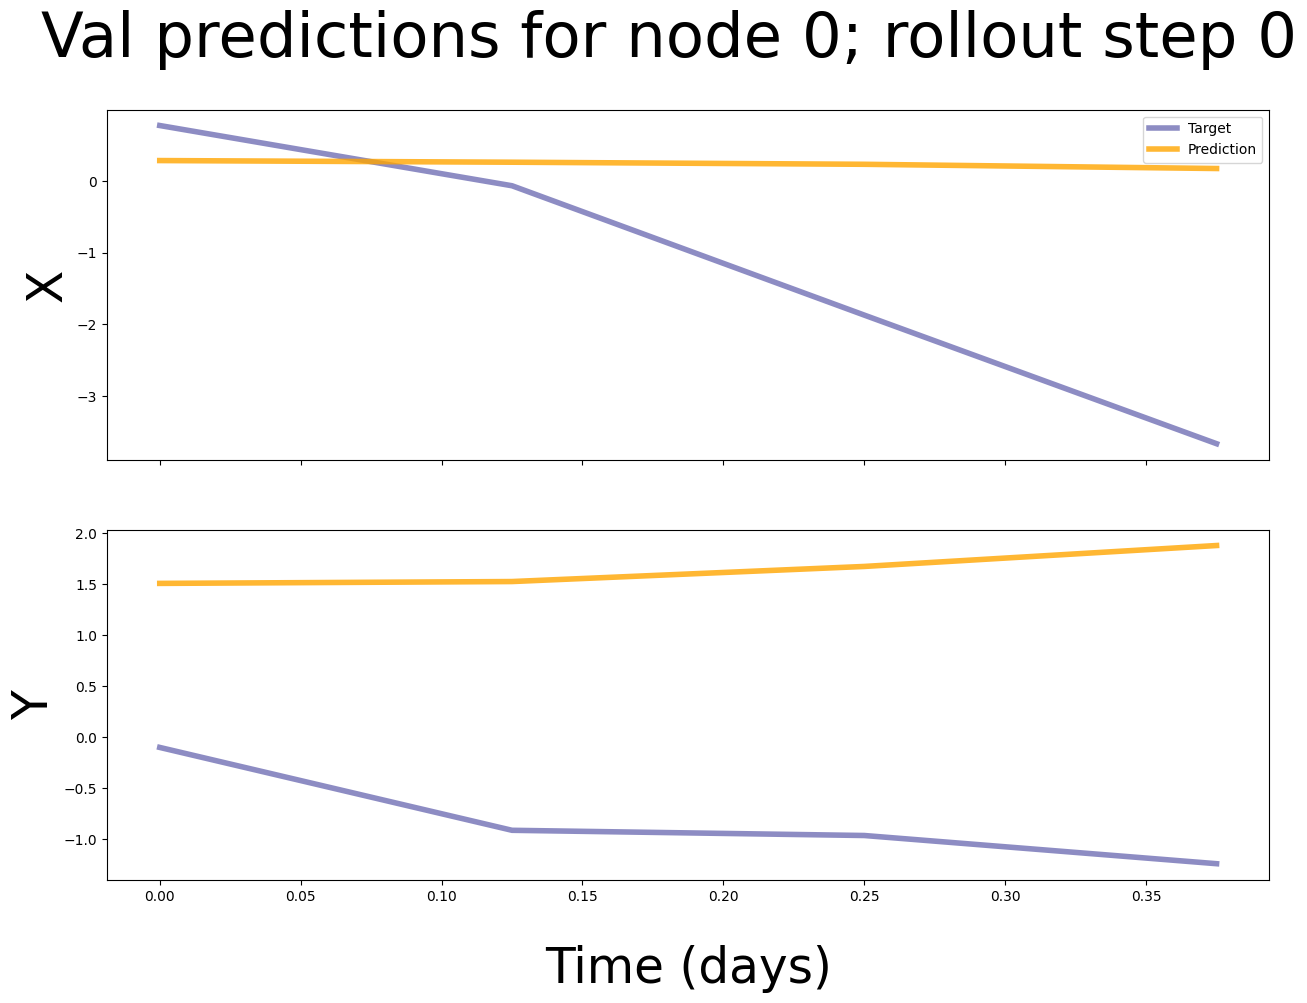

In [142]:
plot_predictions(
    config=get_best_trial_config(study=study),
    workdir=get_best_trial_workdir(study=study), # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets,
    # plot_days=60,
)